In [18]:
import numpy as np
from model import *
from dataloader import *
import matplotlib.pyplot as plt
import random

In [19]:
config = {}
config['epochs'] = 100
config['temperature'] = 1
config['num_neurons'] = 100
config['num_layers'] = 1
config['input_dim'] = None
config['learning_rate'] = 0.001
config['saved_path'] = 'Saved_weights_baseline.pth'
config['validation_loss_path'] = 'val_loss_baseline.out' 
config['training_loss_path'] = 'training_loss_baseline.out' 
config['early_stop_epoch'] = 3
config['early_stopping'] = False

In [20]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [21]:
train_file = open('train.txt', 'r')
train_songs = []

val_file = open('val.txt', 'r')
val_songs = []

test_file = open('test.txt', 'r')
test_songs = []


    
all_characters = train_file.read()
unique_characters = list(set(all_characters))
config['input_dim'] = len(unique_characters)

print((unique_characters))


#create one hot encodings for each unique character in the alphabet of the training data
one_hot_dict_encode = {}
one_hot_dict_decode = {}
index = 0
for unique_character in unique_characters:
    current_encoding = np.zeros(config['input_dim'])
    current_encoding[index] = 1
    
    one_hot_dict_encode[unique_character] = current_encoding
    one_hot_dict_decode[tuple(current_encoding)] = unique_character
    
    index += 1
    
    
#encode end of song token

#start token
current_encoding = np.zeros(config['input_dim'])
current_encoding[93] = 1

one_hot_dict_encode['$'] = current_encoding
one_hot_dict_decode[tuple(current_encoding)] = '$'

#end song token
current_encoding = np.zeros(config['input_dim'])
current_encoding[94] = 1

one_hot_dict_encode['%'] = current_encoding
one_hot_dict_decode[tuple(current_encoding)] = '%'


train_file = open('train.txt', 'r')
train_songs = []

val_file = open('val.txt', 'r')
val_songs = []

test_file = open('test.txt', 'r')
test_songs = []


#split the songs into their own strings, while including start and end tags
song = []
for line in train_file:
    for character in line:
        song.append(one_hot_dict_encode[character])

        if character == '%':
            song.append(one_hot_dict_encode['\n'])
            train_songs.append(song)
            song = []
    
song = []
for line in val_file:
    for character in line:
        song.append(one_hot_dict_encode[character])

        if character == '%':
            song.append(one_hot_dict_encode['\n'])
            val_songs.append(song)
            song = []

song = []
for line in test_file:
    for character in line:
        song.append(one_hot_dict_encode[character])

        if character == '%':
            song.append(one_hot_dict_encode['\n'])
            test_songs.append(song)
            song = []   
            
            
len(unique_characters), len(one_hot_dict_decode)



['N', 'O', 'Q', 'z', '!', 'V', '\\', '~', 'y', '&', 'n', 'm', '\t', 'T', 'w', '-', ',', 'W', 'o', ']', '[', '"', 'M', ')', 's', 'H', 'i', '0', 'r', 'e', 'g', 'v', '@', 'u', '8', '#', 'q', 'X', 'a', 'R', '5', 'l', 'E', ' ', 'c', 'Y', 'k', 'D', 'J', 'p', '/', 'f', '^', '7', '=', '}', '|', '*', 'L', '+', 'd', 'h', 'K', 'S', '<', "'", 'U', 'A', 'x', ':', '.', '\n', '4', '2', '?', 'F', 'P', 'b', '9', 'I', 't', '{', '>', 'Z', 'B', 'j', '1', 'C', '%', 'G', '3', '$', '_', '6', '(']


(95, 95)

In [22]:
a = np.zeros(config['input_dim'])
a[82] = 1
print(one_hot_dict_decode[tuple(a)])

>


In [23]:
model = Lstm(config['input_dim'], config['num_neurons'], config['num_layers']).to(computing_device)

    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

if not os.path.exists(config['saved_path']):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.array([0,0]))
    np.savetxt(config['validation_loss_path'], np.array([0,0]))
    
model, optimizer


(Lstm(
   (lstm_layer): LSTM(95, 100)
   (fc): Linear(in_features=100, out_features=95, bias=True)
 ), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [24]:
#for early stopping
num_times_incraesed = 0
prev_val_loss = float("inf")


#restore the model's weights 
checkpoint = torch.load(config['saved_path'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


for epoch in range(config['epochs']):
    print('EPPPPOCCCHHHHH ' + str(epoch + 1))
    
    total_loss = 0

    #for early stopping
    old_net_weights = model.state_dict()
    old_optimizer = optimizer.state_dict()
    
    #metrics for train and val loss
    training_losses = np.genfromtxt(config['training_loss_path'])
    validation_losses = np.genfromtxt(config['validation_loss_path'])

    #Shuffle the songs 
    random.shuffle(train_songs)
    
    #train
    model.train()
    for song in train_songs:

        #set states to 0 at the beginning of each song
        hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        hidden_state = hidden_state.float()
        cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        cell_state = cell_state.float()
        hidden = (hidden_state, cell_state)

        
        #encode the characters to their respective one hot encoding
        encoded_inputs = song
        
        song_loss = 0
        #train
        num_minibatches = math.ceil(len(encoded_inputs)/100)
        for i in range(num_minibatches):
            model.zero_grad()

            chunk, targets = MyDataset(encoded_inputs)[i]
           
            
            
            if len(chunk) == 0:
                break
            
            #to computing device
            chunk = chunk.to(computing_device)
            targets = targets.to(computing_device)
            
            #forward
            output, hidden = model(chunk, hidden)
            

            
            #loss
            targets = targets.argmax(dim=1)
            loss = criterion(output, targets)
            song_loss += loss
            
            #backprop
            loss.backward(retain_graph=True)
            optimizer.step()
            
        total_loss += song_loss/num_minibatches
      
    #calculate training loss
    average_epoch_loss = total_loss/len(train_songs)
    print('epoch ' + str(epoch + 1) + ' with train error '+ str(average_epoch_loss.cpu().item()))


        

    total_loss = 0
    #validation
    model.eval()
    with torch.no_grad():
        for song in val_songs:
            song_loss = 0
            
            #set states to 0 at the beginning of each song
            hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
            hidden_state = hidden_state.float()
            cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
            cell_state = cell_state.float()
            hidden = (hidden_state, cell_state)


            #encode the characters to their respective one hot encoding
            encoded_inputs = song


            #val
            num_minibatches = math.ceil(len(encoded_inputs)/100)
            for i in range(num_minibatches):

                chunk, targets = MyDataset(encoded_inputs)[i]
                

                if len(chunk) == 0:
                    break

                #to computing device
                chunk = chunk.to(computing_device)
                targets = targets.to(computing_device)

                #forward
                output, hidden = model(chunk, hidden)

                targets = targets.argmax(dim=1)
                
#                 print('hi')
#                 print(output.squeeze().argmax(dim=1))

#                 print('mom')
#                 print(targets)
                loss = criterion(output, targets)
                song_loss += loss
                
            total_loss += song_loss/num_minibatches

                
    #calculate training loss
    average_val_epoch_loss = total_loss/len(val_songs)
    print('epoch ' + str(epoch + 1) + ' with val error '+ str(average_val_epoch_loss.cpu().item()))
    
    
    if config['early_stopping']:
        #early stopping
        if average_val_epoch_loss > prev_val_loss:
            print('keeping old weights')
            num_times_incraesed += 1
            model.load_state_dict(old_net_weights)
            optimizer.load_state_dict(old_optimizer)
        else : 
            print('val is less than previous')
            num_times_incraesed = 0
            prev_val_loss = average_val_epoch_loss

        if num_times_incraesed >= config['early_stop_epoch']:
            print('early stopping triggered')
            break       
            
            
    #save model and loss
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.append(training_losses, average_epoch_loss.cpu().item()))
    np.savetxt(config['validation_loss_path'], np.append(validation_losses, average_val_epoch_loss.cpu().item()))
        

EPPPPOCCCHHHHH 1
epoch 1 with train error 2.6265718936920166
epoch 1 with val error 2.2819409370422363
EPPPPOCCCHHHHH 2
epoch 2 with train error 1.8208980560302734
epoch 2 with val error 1.8868529796600342
EPPPPOCCCHHHHH 3
epoch 3 with train error 1.596938967704773
epoch 3 with val error 1.789360523223877
EPPPPOCCCHHHHH 4
epoch 4 with train error 1.4789568185806274
epoch 4 with val error 1.7459514141082764
EPPPPOCCCHHHHH 5
epoch 5 with train error 1.4047659635543823
epoch 5 with val error 1.7023038864135742
EPPPPOCCCHHHHH 6
epoch 6 with train error 1.345504641532898
epoch 6 with val error 1.6539688110351562
EPPPPOCCCHHHHH 7
epoch 7 with train error 1.3055180311203003
epoch 7 with val error 1.6470122337341309
EPPPPOCCCHHHHH 8
epoch 8 with train error 1.2735228538513184
epoch 8 with val error 1.6225864887237549
EPPPPOCCCHHHHH 9
epoch 9 with train error 1.2417042255401611
epoch 9 with val error 1.6142029762268066
EPPPPOCCCHHHHH 10
epoch 10 with train error 1.217301845550537
epoch 10 with 

KeyboardInterrupt: 

[2.28194094 1.88685298 1.78936052 1.74595141 1.70230389 1.65396881
 1.64701223 1.62258649 1.61420298 1.59925234 1.59877002 1.60562408
 1.59086812 1.58981013 1.58036005 1.57138371 1.57090199 1.58714521
 1.58600569 1.60963833 1.62438679]


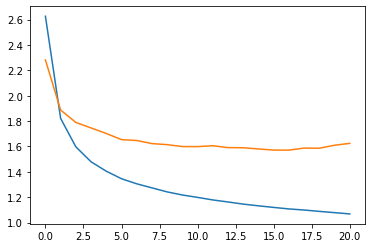

In [25]:
training_losses = np.genfromtxt(config['training_loss_path'])[2:]
validation_losses = np.genfromtxt(config['validation_loss_path'])[2:]
print(validation_losses)

x_axis = []
for i in range(len(training_losses)):
    x_axis.append(i)

plt.figure()
plt.plot(x_axis, training_losses)
plt.plot(x_axis, validation_losses)

In [ ]:
#get first initial input
# cell_state = torch.from_numpy(np.array(one_hot_enocode['X'])).float()[:,None,:] 
print(cell_state)
                
#init hidden state
hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
hidden_state = hidden_state.float()
cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
cell_state = cell_state.float()
hidden = (hidden_state, cell_state)

#generate music
model.eval()
with torch.no_grad():
    while True: 
        cell_state, hidden = model(cell_state.to(computing_device), hidden)
        break
        
      